# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 18: Generalized Linear Models III. Multinomial Logistic Regression. Regularization of MNR. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - parameters
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()
# - rng
rng = np.random.default_rng()
# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

## 1. Multinomial Regression

The Multinomial Regression model is a powerful classification tool. Consider a problem where some outcome variable can result in more than two discrete outcomes. For example, a customer visiting a webshop can end up their visit (a) buying nothing, (b) buying some Product A, or (c) Product B, or (d) Product C, etc. If we have some information about a particular customer's journey through the website (e.g. how much time did they spend on some particular pages, did they visit the webshop before or not, or any other information that customers might have chose to disclose on their sign-up...), we can use it as a set of predictors of customer behavior resulting in any of the (a), (b), (c), (d). We do that by means of a simple extension of the Binomial Logistic Regression that is used to solve for dichotomies: enters the Multinomial Regression model.

### The Model

First, similar to what happens in *dummy coding*, given a set of $K$ possible outcomes we choose one of them as a *baseline*. Thus all results of the Multionomial Regression will be interpreted as effects relative to that baseline outcome category, for example: for a unit increase in predictor $X_1$ what is the change in odds to switch from (a) buying nothing to (b) buying Product A. We are already familiar with this logic, right?

So, consider a set of $K-1$ independent Binary Logistic Models with only one predictor $X$ where the baseline is now referred to as $K$:

$$log\frac{P(Y_i = 1)}{P(Y_i = K)} = \beta_{1,0} + \beta_{1,1}X$$

$$log\frac{P(Y_i = 2)}{P(Y_i = K)} = \beta_{2,0} + \beta_{2,1}X$$

$$log\frac{P(Y_i = K-1)}{P(Y_i = K)} = \beta_{K-1,0} + \beta_{K-1,1}X$$

Obviously, we are introducing a set of new regression coefficients ($\beta_{k,\cdot}$) for each possible value of the outcome $k = 1, 2,.., K-1$. The *log-odds* are on the LHS while the linear model remains on the RHS.

Now we exponentiate the equations to arrive at the expressions for *odds*:

$$\frac{P(Y_i = 1)}{P(Y_i = K)} = e^{\beta_{1,0} + \beta_{1,1}X}$$

$$\frac{P(Y_i = 2)}{P(Y_i = K)} = e^{\beta_{2,0} + \beta_{2,1}X}$$

$$\frac{P(Y_i = K-1)}{P(Y_i = K)} = e^{\beta_{K-1,0} + \beta_{K-1,1}X}$$

And solve for $P(Y_i = 1), P(Y_i = 2),.. P(Y_i = K-1)$:

$$P(Y_i = 1) = P(Y_i = K)e^{\beta_{1,0} + \beta_{1,1}X}$$

$$P(Y_i = 2) = P(Y_i = K)e^{\beta_{2,0} + \beta_{2,1}X}$$

$$P(Y_i = K-1) = P(Y_i = K)e^{\beta_{K-1,0} + \beta_{K-1,1}X}$$

From the fact that all probabilities $P(Y_i = 1), P(Y_i = 2), .., P(Y_i = K)$ must sum to one it can be shown that

$$P(Y_i = K) = \frac{1}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

Because:

(1) $P(Y_i = 1) + P(Y_i = 2) + ... + P(Y_i = K) = 1$, we have

(2) $P(Y_i = K) + P(Y_i = K)e^{\beta_{1,0} + \beta_{1,1}X} + P(Y_i = K)e^{\beta_{2,0} + \beta_{2,1}X} + ... + P(Y_i = K=1)e^{\beta_{K-1,0} + \beta_{K-1,1}X} = 1$ 

(3) and then replace $e^{\beta_{1,0} + \beta_{1,1}X}$ by $l_1$, $e^{\beta_{2,0} + \beta_{2,1}X}$ by $l_2$, and $e^{\beta_{k,0} + \beta_{k,1}X}$ by $l_k$ in the general case, we have

(4) $P(Y_i = K) + P(Y_i = K)e^{l_1} + P(Y_i = K)e^{l_2} + ... + P(Y_i = K-1)e^{l_{K-1}} = 1$

(5) $P(Y_i = K)[1 + e^{l_1} + e^{l_2} + ... + e^{l_{K-1}}] = 1$ so that 

(6) $P(Y_i = K) = \frac{1}{1 + e^{l_1} + e^{l_2} + ... + e^{l_{K-1}}} = \frac{1}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$

It is easy now to derive the expressions for all $K-1$ probabilities of the outcome resulting in a particular class:

$$P(Y_i = 1) = \frac{e^{\beta_{1,0} + \beta_{1,1}X}}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

$$P(Y_i = 2) = \frac{e^{\beta_{2,0} + \beta_{2,1}X}}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

$$P(Y_i = K-1) = \frac{e^{\beta_{K-1,0} + \beta_{K-1,1}X}}{1+\sum_{k=1}^{K-1}e^{\beta_{k,0} + \beta_{k,1}X}}$$

In [2]:
# - loading the dataset
# - Kaggle: https://www.kaggle.com/datasets/uciml/iris
# - place it in your _data/ directory
iris_data = pd.read_csv(os.path.join(data_dir, 'Iris.csv'), index_col='Id')
iris_data.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


In [3]:
# - counting the instances of each category
iris_data['Species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

In [4]:
# - info on the variables
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


### Target: predict species from all continuous predictors

We use Multinomial Logistic Regression Model to predict the most probable category for the given observation $\textbf{x}$ with features $(x_1, x_2, \ldots, x_k)$. Assume that our target variable $y$ belongs to one of categories from the set $\{1, 2, \ldots, C\}$. In MNR we usually select one category as the referrence category; let that be the category $C$. Then, the probability that the target variable $y$ belongs to category $c = 1,\ldots,C-1$ is calculated via

$$P(y = c) = \frac{e^{\beta^{(c)}_1x_1 + \beta^{(c)}_2x_2 + \cdots + \beta^{(c)}_kx_k + \beta_0}}{1+\sum_{j=1}^{C-1}e^{\beta^{(j)}_1x_1 + \beta^{(j)}_2x_2 + \cdots + \beta^{(j)}_kx_k + \beta_0}},$$

and the probability that it belogns to the referrence category $C$ is 

$$P(y = C) = \frac{1}{1+\sum_{j=1}^{C-1}e^{\beta^{(j)}_1x_1 + \beta^{(j)}_2x_2 + \cdots + \beta^{(j)}_kx_k + \beta_0}},$$

where $\beta^{(j)}_1, \beta^{(j)}_2, \ldots, \beta^{(j)}_k,\ j=1,\ldots,C$ are the model's parameters for predictors and target variable categories, and $n$ is the intercept of the model.

After calculating all the probabilities $P(y = c),\ c=1,\ldots,C$ we predict the target variable as

$$\hat{y} = \textrm{argmax}_{c=1,\ldots,C}P(y=c).$$

The model is estimated by MLE (Maximum Likelihood Estimation). For each category $c$ - except for the referrence $C$, of course - we obtain a set of coefficients. Each model coefficient, in each category, tells us about the $\Delta_{odds}$ in favor of the target category, for a unit change of a predictor, in comparison with the baseline category, and given that everything else is kept constant.

In [5]:
### --- Preparing the variables 

# - feature matrix
X = iris_data.drop(columns='Species')
# - we append a constant column of ones to the feature matrix
X = sm.add_constant(X)
print(X[:10])


# - we impose the ordering to the categories of the target vector; the first category is the referrence category
cat_type = pd.CategoricalDtype(categories=["Iris-versicolor", "Iris-virginica", "Iris-setosa"], ordered=True)
y = iris_data['Species'].astype(cat_type)

    const  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
Id                                                                 
1     1.0            5.1           3.5            1.4           0.2
2     1.0            4.9           3.0            1.4           0.2
3     1.0            4.7           3.2            1.3           0.2
4     1.0            4.6           3.1            1.5           0.2
5     1.0            5.0           3.6            1.4           0.2
6     1.0            5.4           3.9            1.7           0.4
7     1.0            4.6           3.4            1.4           0.3
8     1.0            5.0           3.4            1.5           0.2
9     1.0            4.4           2.9            1.4           0.2
10    1.0            4.9           3.1            1.5           0.1


In [6]:
# - fitting the MNR model to the data; we use the Newton's Conjugate Gradient method as the optimizer to compute the
# - models coefficients
mnr_model = sm.MNLogit(exog=X, endog=y).fit(method='ncg', maxiter=150)
mnr_model.summary()

Optimization terminated successfully.
         Current function value: 0.039663
         Iterations: 116
         Function evaluations: 117
         Gradient evaluations: 117
         Hessian evaluations: 116


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                Species   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Wed, 03 May 2023   Pseudo R-squ.:                  0.9639
Time:                        15:18:24   Log-Likelihood:                -5.9494
converged:                       True   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 7.056e-64
=======================================================================================
Species=Iris-virginica       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -42.6378     25.707     -1.659      0.097     -93.023       7.748
SepalLengthCm             -2.4650      2.394     -1.030      0.303      -7.158       2.228
SepalWidthCm              -6.6814      4.480     -1.491      0.136     -15.461       2.099
PetalLengthCm              9.4294      4.737      1.990      0.047       0.145      18.714
PetalWidthCm              18.2859      9.743      1.877      0.061      -0.809      37.381
------------------------------------------------------------------------------------------
Species=Iris-setosa       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2464   2814.348      0.000      1.000   -5514.774    5517.267
SepalLengthCm           2.1570    796.124      0.003      0.998   -1558.216    1562.531
SepalWidthCm            6.3632    392.430      0.016      0.987    -762.785     775.511
PetalLengthCm         -10.6666    514.181     -0.021      0.983   -1018.443     997.110
PetalWidthCm           -5.4860    974.930     -0.006      0.996   -1916.313    1905.341
=======================================================================================
"""

In [7]:
# - confusion matrix for our model and given data; rows/columns are on par with the ordering of categorical variable
mnr_model.pred_table()

array([[49.,  1.,  0.],
       [ 1., 49.,  0.],
       [ 0.,  0., 50.]])

In [8]:
# - accuracy of the model
correct_classes = np.trace(mnr_model.pred_table())
print(f'Correct observations: {correct_classes}')
num_obs = np.sum(mnr_model.pred_table())
print(f'Total observations: {num_obs}')
print(f'The accuracy of our model: {round(correct_classes/num_obs, 4)}')

Correct observations: 148.0
Total observations: 150.0
The accuracy of our model: 0.9867


In [9]:
# - model's prediction of probabilities; columns correspond to the ordering of categorical variable
mnr_model.predict()[:10]

array([[9.34872753e-09, 1.44324732e-35, 9.99999991e-01],
       [3.46621493e-07, 2.47392957e-32, 9.99999653e-01],
       [5.14366413e-08, 6.15260257e-34, 9.99999949e-01],
       [1.01809267e-06, 2.00366351e-31, 9.99998982e-01],
       [6.13878953e-09, 6.21664320e-36, 9.99999994e-01],
       [2.82201171e-08, 9.42229344e-34, 9.99999972e-01],
       [8.98984023e-08, 5.77985326e-33, 9.99999910e-01],
       [6.36830880e-08, 6.30010984e-34, 9.99999936e-01],
       [1.92574911e-06, 9.19522343e-31, 9.99998074e-01],
       [3.07960805e-07, 4.64760530e-33, 9.99999692e-01]])

In [10]:
# - model's prediction of categories; numbers correspond to the ordering of categorical variable
preds = np.argmax(mnr_model.predict(), axis=-1)
preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### Multicolinearity in Multinomial Regression

In [11]:
# - Step 1: recode categorical target variable to integer values, 
# - just in order to be able to run a multiple linear regression on the data:
y_code = y.cat.codes
y_code

Id
1      2
2      2
3      2
4      2
5      2
      ..
146    1
147    1
148    1
149    1
150    1
Length: 150, dtype: int8

In [12]:
### --- Step 2: produce a Multiple Linear Regression model for the data 
mnr_model = sm.OLS(exog=X, endog=y_code).fit()
mnr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     48.17
Date:                Wed, 03 May 2023   Prob (F-statistic):           1.02e-25
Time:                        15:18:26   Log-Likelihood:                -119.03
No. Observations:                 150   AIC:                             248.1
Df Residuals:                     145   BIC:                             263.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4405      0.509     -0.866      0.388      -1.446       0.565
SepalLengthCm     0.0872      0.143      0.608      0.544      -0.196       0.371
SepalWidthCm      0.6832      0.149      4.586      0.000       0.389       0.978
PetalLengthCm    -0.4413      0.142     -3.117      0.002      -0.721      -0.161
PetalWidthCm      0.4198      0.235      1.789      0.076      -0.044       0.884
==============================================================================
Omnibus:                       28.857   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.904
Skew:                          -0.222   Prob(JB):                       0.0192
Kurtosis:                       1.966   Cond. No.                         91.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# --- Step 3: compute VIFs for the predictors
predictors = iris_data.columns.drop('Species')
predictors

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

In [14]:
# - appending the columns of ones to the predictors' data
model_frame_predictors = sm.add_constant(iris_data[predictors])

In [15]:
# - computing VIFs
vifs = [variance_inflation_factor(model_frame_predictors.values, i) for i in range(1, len(predictors)+1)]
vifs = np.array(vifs).reshape(1, -1)
pd.DataFrame(vifs, columns=predictors)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,7.103113,2.099039,31.397292,16.141564


### Multinomial Logistic Regression using scikit-learn

In [16]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [17]:
# - Preparing the variables 

# - feature matrix
X = iris_data.drop(columns='Species').values

# - target variable
y = iris_data['Species']

**N.B.** scikit-learn does not implement the referrence category automatically! 

In [18]:
# - Fitting the logistic model to the numerical data
# - scikit-learn does not implement the referrence category automatically 
log_reg = LogisticRegression(solver='newton-cg', penalty='none')
log_reg.fit(X, y)

LogisticRegression(penalty='none', solver='newton-cg')

In [19]:
# - coefficents of the model; rows correspond to the order of appearance of categories in the target variable
log_reg.coef_, log_reg.intercept_

(array([[  4.88501685,   7.84683378, -12.83914117,  -6.66236914],
        [ -1.20989943,  -0.58296936,   1.70486765,  -5.81189786],
        [ -3.67511742,  -7.26386442,  11.13427351,  12.47426701]]),
 array([  2.32878337,  20.15458005, -22.48336342]))

In [20]:
# - model's accuracy
round(log_reg.score(X, y), 4)

0.9867

In [21]:
# - predictions
y_pred = log_reg.predict(X)
y_pred[:10]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

In [22]:
# - confusion matrix for the given data
# - rows/columns rows correspond to the order of appearance of categories in the target variable
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]], dtype=int64)

## 2. Regularization of Multinomial Regression

In [23]:
# - loading the dataset
# - UCI ML: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) (download winequality-red.csv)
# - place it in your _data/ directory
wine_data = pd.read_csv(os.path.join(data_dir, 'winequality-red.csv'), sep=';')
wine_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


### Target: predict wine quality from all the predictors

In [24]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [25]:
predictors = wine_data.columns.drop('quality')
predictors

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [26]:
# - converting 'quality' variable which is numerical into ordered categorical
wine_data['quality'] = wine_data['quality'].astype(pd.CategoricalDtype(ordered=True))
wine_data['quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1599 entries, 0 to 1598
Series name: quality
Non-Null Count  Dtype   
--------------  -----   
1599 non-null   category
dtypes: category(1)
memory usage: 1.9 KB


In [27]:
wine_data['quality'].head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: category
Categories (6, int64): [3 < 4 < 5 < 6 < 7 < 8]

In [28]:
wine_data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [29]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality')
# - we append a constant column of ones to the feature matrix
X = sm.add_constant(X)

# - target vector
y = wine_data['quality']

In [30]:
# - fitting the MNR model to the data; we use the Newton's Conjugate Gradient method as the optimizer to compute the
#models coefficients
mnr_model = sm.MNLogit(exog=X, endog=y).fit(method='ncg', maxiter=100)
mnr_model.summary()

Optimization terminated successfully.
         Current function value: 0.913760
         Iterations: 46
         Function evaluations: 78
         Gradient evaluations: 78
         Hessian evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                quality   No. Observations:                 1599
Model:                        MNLogit   Df Residuals:                     1539
Method:                           MLE   Df Model:                           55
Date:                Wed, 03 May 2023   Pseudo R-squ.:                  0.2287
Time:                        15:18:44   Log-Likelihood:                -1461.1
converged:                       True   LL-Null:                       -1894.2
Covariance Type:            nonrobust   LLR p-value:                2.987e-146
========================================================================================
           quality=4       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  150.7854    547.752      0.275      0.783    -922.789    1224.360
fixed acidity           -0.6119      0.688     -0.889      0.374      -1.961       0.737
volatile acidity        -4.8509      2.448     -1.981      0.048      -9.649      -0.052
citric acid             -2.3627      4.063     -0.581      0.561     -10.326       5.601
residual sugar           0.1666      0.312      0.533      0.594      -0.446       0.779
chlorides              -10.3956      7.560     -1.375      0.169     -25.212       4.421
free sulfur dioxide     -0.1601      0.091     -1.757      0.079      -0.339       0.018
total sulfur dioxide     0.0839      0.050      1.678      0.093      -0.014       0.182
density               -131.9670    557.829     -0.237      0.813   -1225.292     961.358
pH                      -7.1129      5.073     -1.402      0.161     -17.056       2.831
sulphates                1.1854      3.746      0.316      0.752      -6.156       8.527
alcohol                  1.5048      0.877      1.715      0.086      -0.215       3.225
----------------------------------------------------------------------------------------
           quality=5       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -104.0851    522.960     -0.199      0.842   -1129.067     920.897
fixed acidity           -0.9018      0.651     -1.386      0.166      -2.177       0.373
volatile acidity        -7.8053      2.408     -3.241      0.001     -12.525      -3.086
citric acid             -2.7974      3.904     -0.716      0.474     -10.450       4.855
residual sugar          -0.1348      0.298     -0.453      0.651      -0.719       0.449
chlorides              -12.8486      6.884     -1.867      0.062     -26.340       0.643
free sulfur dioxide     -0.1366      0.088     -1.545      0.122      -0.310       0.037
total sulfur dioxide     0.0994      0.049      2.011      0.044       0.003       0.196
density                143.4813    532.630      0.269      0.788    -900.455    1187.417
pH                     -10.8172      4.888     -2.213      0.027     -20.398      -1.237
sulphates                0.9416      3.538      0.266      0.790      -5.994       7.877
alcohol                  1.4625      0.852      1.717      0.086      -0.207       3.132
----------------------------------------------------------------------------------------
           quality=6       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -71.9561    524.277     -0.137      0.891   -1099.519     955.607
fixed acidity           -0.7707      0.651     -1.184      0.236      -2.046       0.505
volatile acidity       -10.4437      2.432     -4.294      0.000     -15.211      -5.676
citric acid             -4.0991      

In [31]:
# - confusion matrix for the model prdictions; ordering of rows/columns correspond to the oredering of the classes
conf_matrix = mnr_model.pred_table()
conf_matrix

array([[  2.,   0.,   7.,   1.,   0.,   0.],
       [  1.,   1.,  34.,  15.,   2.,   0.],
       [  2.,   0., 514., 159.,   6.,   0.],
       [  0.,   0., 207., 391.,  40.,   0.],
       [  0.,   0.,  13., 120.,  66.,   0.],
       [  0.,   0.,   0.,  10.,   8.,   0.]])

In [32]:
# - accuracy of the model
mnr_acc = np.sum(np.diag(conf_matrix))/np.sum(conf_matrix)
mnr_acc

0.6091307066916823

### Regularization of the model coefficients: Ridge (L2) Regularization

Now we are going to use scikit-learn to perform *Regularized* Multinomial Logistic Regression; we'll be using the Ridge Regression. 

The Ridge Regression model is obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_2^2,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_2^2$ is the squared *Frobenius norm* of model parameters matrix $W$:

$$L_2^2 = ||W||_F^2 = \sum_{i=1}^k\sum_{j=1}^K(\beta_i^{(j)})^2;$$

$k$ is the number of predictors, $K$ number of categories of the targert variable, and $\beta_i^{(j)}$ are model parameters. $C$ is the *Regularization (hyper)parameter* and it the invers of penalization hyperparameter $\alpha$.

In [152]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix

In [153]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality').values

# - target variable
y = wine_data['quality']

In [158]:
### --- Fitting a Ridge MNR Regularized model on the given data, with the regularization parameter C = 250

# - NOTE: LogisticRegression from scikit-learn implements L2 regularization BY DEFAULT
# - so, you actually don't need to pass 'penalty' parameter in order to implement Ridge Regularization
# - if you want to perform MNR without any regularization with scikit-learn, you need to pass 'penalty=none' parameter

log_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=250)
log_reg.fit(X, y)

LogisticRegression(C=250, solver='newton-cg')

In [159]:
# - intercept of the model; entries correspond to the orderdering of the categories in the target variable 
log_reg.intercept_

array([-21.92075208,   1.95548122,   8.43134916,   2.14612481,
         2.8028652 ,   6.58493168])

In [160]:
# - coefficents of the model; rows correspond to the ordering of the categories in the target variable;
# - columns correspond to the predictors
log_reg.coef_

array([[ 6.14803951e-01,  7.56763474e+00,  2.45865287e+00,
         1.14608834e-02,  1.40139205e+01,  1.04510711e-01,
        -6.66259221e-02,  3.69122587e-01,  8.72678197e+00,
        -2.72743545e+00, -1.87880504e+00],
       [-1.13518559e-01,  2.80313116e+00,  1.59509973e-01,
         1.14656962e-01,  5.27580878e+00, -5.30471209e-02,
         1.69277450e-02, -3.07275513e+00,  1.44599702e+00,
        -2.27686797e+00, -3.21108286e-01],
       [-1.08836596e-01, -2.44317524e-01, -5.78272970e-01,
        -7.99026847e-02,  3.61521325e+00, -3.29943230e-02,
         3.37384507e-02,  4.80080982e+00, -7.93598622e-01,
        -2.17469094e+00, -5.90818556e-01],
       [-1.57653049e-02, -2.89753100e+00, -1.86281805e+00,
        -4.66663039e-02,  9.91879988e-01, -1.13792937e-02,
         1.73276089e-02,  3.33634205e+00, -9.78561474e-01,
         1.27877313e-01,  2.27470082e-01],
       [ 3.77687787e-02, -5.39289727e+00, -1.43891422e+00,
         9.54358594e-02, -6.43978670e+00, -6.89353735e-03,
  

In [161]:
# - accuracy of Ridge Regularization
log_reg.score(X, y)

0.610381488430269

We managed to obtain a small improvement: 61.04% accuracy, against 60.91% of the baseline model. But, can we do better?

In [162]:
### --- Varying the regularization parameter for the Ridge Regularized Model
n_Cs = 25
Cs = np.linspace(1e-2, 500, n_Cs)

l2_coefs = []
accuracies = []
frob_norms_matrix = []
for C in Cs:
    
    # - fitting a Ridge Regularization
    ridge = LogisticRegression(solver='newton-cg', C=C, max_iter=1000)
    ridge.fit(X, y)
    
    # - squared L2 norm of model coefficients vectors for each category
    l2_c = np.linalg.norm(ridge.coef_, ord=2, axis=0)**2
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - squared Frobenius norm of model coefficient matrix
    frob = np.linalg.norm(ridge.coef_, ord=2)**2
    
    l2_coefs.append(l2_c)
    accuracies.append(acc)
    frob_norms_matrix.append(frob)

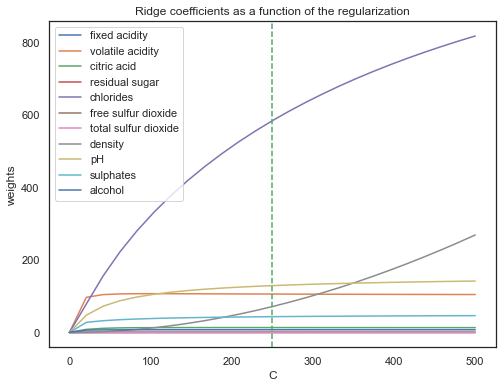

In [163]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l2_coefs)
ax.axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
plt.xlabel("C")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

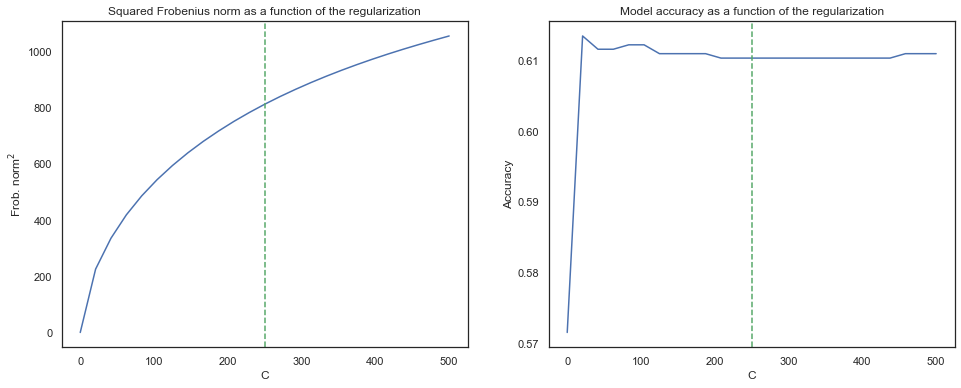

In [54]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - squared Frobenius vs. C
ax[0].plot(Cs, frob_norms_matrix)
ax[0].axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
ax[0].set_xlabel("C")
ax[0].set_ylabel("Frob. norm$^2$")
ax[0].set_title("Squared Frobenius norm as a function of the regularization")
ax[0].axis("tight")

# - accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].axvline(x=250, c='g', ls='--') # green line
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

From the right graph above, we may assume that for regularization hyperparameter C ~ 12.5 we may obtain a good approximation of the best model.

In [55]:
### --- Fitting an assumed approximation of the best Ridge Regularized model
ridge_best = LogisticRegression(C=12.5, solver='newton-cg')
ridge_best.fit(X, y)

LogisticRegression(C=12.5, solver='newton-cg')

In [56]:
ridge_best.intercept_

array([-5.36870319, -0.40200138, 11.58437309,  3.49235553, -4.55844927,
       -4.74757479])

In [57]:
ridge_best.coef_

array([[ 3.45549775e-01,  6.58733940e+00,  1.36310056e+00,
         9.23288000e-02,  3.03620804e+00,  8.65226195e-02,
        -6.34795536e-02,  2.68289765e-02,  3.83621757e+00,
        -1.03498214e+00, -1.53389937e+00],
       [-1.28796833e-01,  2.91022314e+00,  4.25363277e-01,
         1.16383928e-01,  1.81702215e+00, -4.80549423e-02,
         1.45603721e-02, -1.43138264e-01,  1.44750820e+00,
        -1.93177259e+00, -3.85766308e-01],
       [-8.69221363e-02,  6.00823040e-02, -1.86469471e-01,
        -7.78867289e-02,  2.24085323e+00, -2.76364534e-02,
         3.12840393e-02,  2.63178557e-01, -2.91219185e-01,
        -2.28454575e+00, -6.66343573e-01],
       [ 1.11162390e-02, -2.53942397e+00, -1.44085328e+00,
        -4.64611861e-02,  2.20915151e-01, -6.14488130e-03,
         1.49491281e-02,  1.89260606e-01, -3.73775558e-01,
        -1.14570432e-01,  1.55758454e-01],
       [ 6.53378941e-02, -5.04475830e+00, -1.07785365e+00,
         8.43238762e-02, -4.14733996e+00, -2.33029029e-03,
  

In [58]:
# - accuracy of our model
ridge_best.score(X, y)

0.6128830519074422

We did manage to obtain even more accurate model! (61.29% against 61.04% accuracy for C=250, and 60.91% for unregularized model) But, is this the best we can?

### LASSO (L1) Regularization

*LASSO* is another way to regularize MNR model. It's obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_1,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_1$ is the $L_1$ norm of model parameters matrix $W$:

$$L_1 = ||W||_1 = \sum_{i=1}^k\sum_{j=1}^K|\beta_i^{(j)}|.$$

$C$ is, of course regularization hyperparameter.

In [169]:
### --- Varying the penalization parameter for the LASSO Regularized Model
n_Cs = 25
Cs = np.linspace(1e-2, 500, n_Cs)

l1_coefs = []
accuracies = []
l1_norms_matrix = []
for C in Cs:
    # - fitting a LASSO Regularization
    # - when using 'saga' solver, we need to set multi_class='multinomial' argument explicitly
    ridge = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l1', C=C, max_iter=10**5)
    ridge.fit(X, y)
    
    # - L1 norm of model coefficients vectors for each category
    l1_c = np.linalg.norm(ridge.coef_, ord=1, axis=0)
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - L1 norm of model coefficient matrix
    l1_m = np.linalg.norm(ridge.coef_, ord=1)
    
    l1_coefs.append(l1_c)
    accuracies.append(acc)
    l1_norms_matrix.append(l1_m)

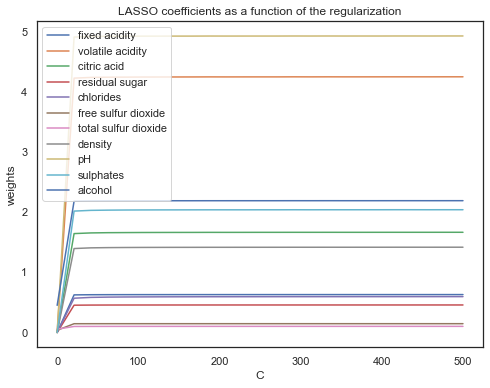

In [170]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l1_coefs)
plt.xlabel("C")
plt.ylabel("weights")
plt.title("LASSO coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

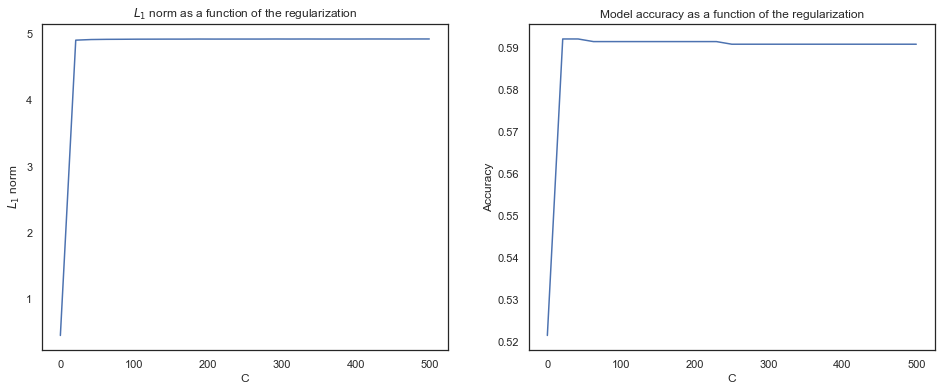

In [171]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - L1-norm vs. C
ax[0].plot(Cs, l1_norms_matrix)
ax[0].set_xlabel("C")
ax[0].set_ylabel("$L_1$ norm")
ax[0].set_title("$L_1$ norm as a function of the regularization")
ax[0].axis("tight")

# - Model accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

In [172]:
# - fitting an assumed best approximation for C = 12.5
lasso_best = LogisticRegression(C=12.5, solver='saga', penalty='l1', multi_class='multinomial', max_iter=10**5)
lasso_best.fit(X, y)

LogisticRegression(C=12.5, max_iter=100000, multi_class='multinomial',
                   penalty='l1', solver='saga')

In [173]:
lasso_best.intercept_

array([ 0.01653163,  0.07951739,  0.61367716, -0.01770283, -0.51636025,
       -0.1756631 ])

In [174]:
lasso_best.coef_

array([[ 9.62303819e-02,  3.34984285e-01, -6.92752142e-02,
         1.06553596e-01,  2.82438443e-02,  5.02023018e-02,
        -4.80317131e-02,  1.39354651e-02,  1.31709414e-01,
        -5.22921589e-02, -2.86866736e-01],
       [-1.12590384e-01,  7.38204358e-01, -2.51165010e-01,
         1.01256713e-01,  2.01125432e-02, -4.11046018e-02,
         1.08700810e-02,  7.20921765e-02,  4.62082408e-01,
        -1.65791336e-01, -1.49553505e-01],
       [ 1.37701483e-01,  1.03224417e+00, -2.46823400e-01,
        -8.04668792e-02,  2.27274705e-01, -1.75461953e-02,
         2.82120185e-02,  6.05433387e-01,  1.69815540e+00,
        -7.82320341e-01, -6.50410199e-01],
       [ 6.37433764e-02, -5.07520168e-01, -2.40435632e-01,
        -6.38748218e-02, -6.18810465e-02,  9.57210190e-03,
         8.41535028e-03, -7.21729022e-03,  1.52877102e-01,
         2.42385773e-01,  8.78155862e-02],
       [ 6.76714501e-03, -1.34308293e+00,  6.10496352e-01,
         1.79389666e-02, -1.80510488e-01,  1.25811192e-02,
  

In [175]:
lasso_best.score(X, y)

0.5909943714821764

Unfortunately, for our case, LASSO regularization did not provide a better model (59.1% accuracy against 60.91% of the baseline model); at least for the selected value ($C$ = 12.5) of the regularization hyperparameter.

## 3. Cross-Validation of Multinomial Regression

In order to find the most optimal penalization hyperparameter we may use *cross-validation* across the 'grid' of hyperparameters, fitting a model for every $C$ in the grid, and then choosing the best perfoming-one (i.e. with the highest accuracy).

### CV for Ridge (L2) Regularization

In [151]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
ridgeCV = LogisticRegressionCV(Cs=10, solver='newton-cg', multi_class='multinomial', max_iter=1000)
ridgeCV.fit(X, y)

LogisticRegressionCV(max_iter=1000, multi_class='multinomial',
                     solver='newton-cg')

In [94]:
# - regularization hyperparameters for the best model
# - note that we do not obtain a single C, but a set of regularization hyperparameters
# - each entry corresponds to the best regularization value for a given category
ridgeCV.C_

array([21.5443469, 21.5443469, 21.5443469, 21.5443469, 21.5443469,
       21.5443469])

In [95]:
ridgeCV.intercept_

array([-8.70703436, -0.6268013 , 11.60633644,  3.69046602, -3.80397255,
       -2.15899426])

In [96]:
ridgeCV.coef_

array([[ 3.92136523e-01,  7.10622562e+00,  1.91394294e+00,
         7.46392207e-02,  4.57710990e+00,  9.24234412e-02,
        -6.52203648e-02,  4.34018924e-02,  4.93801348e+00,
        -1.22160998e+00, -1.66053591e+00],
       [-1.21534890e-01,  2.90788123e+00,  3.71505773e-01,
         1.15774455e-01,  2.51955341e+00, -4.94293304e-02,
         1.52333700e-02, -2.53675412e-01,  1.49553963e+00,
        -2.08825508e+00, -3.65376147e-01],
       [-8.72968281e-02, -3.02295076e-02, -3.16930577e-01,
        -7.78551242e-02,  2.44378230e+00, -2.92766472e-02,
         3.20699892e-02,  4.42747262e-01, -3.87376376e-01,
        -2.31298916e+00, -6.41490196e-01],
       [ 9.36081293e-03, -2.65791244e+00, -1.58917105e+00,
        -4.59737341e-02,  2.61416751e-01, -7.79036318e-03,
         1.57259097e-02,  3.17240946e-01, -5.00145962e-01,
        -1.02728491e-01,  1.80037670e-01],
       [ 6.19513711e-02, -5.19631840e+00, -1.23124123e+00,
         8.75564597e-02, -4.92405100e+00, -3.78764476e-03,
  

In [97]:
# - accuracy of the model obtained through the cross-validation
ridgeCV.score(X, y)

0.6135084427767354

We have managed to obtained and even more accurate model through Ridge Regularization and cross-validation! (compared with 60.91% accuracy of unregularized model, and 61.29% accuracy of regularized, but without CV)

In [105]:
confusion_matrix(y, ridgeCV.predict(X))

array([[  1,   1,   7,   1,   0,   0],
       [  0,   1,  35,  16,   1,   0],
       [  2,   0, 517, 158,   4,   0],
       [  0,   0, 206, 397,  35,   0],
       [  0,   0,  13, 121,  65,   0],
       [  0,   0,   0,  10,   8,   0]], dtype=int64)

### CV for LASSO (L1) Regularization

In [176]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
lassoCV = LogisticRegressionCV(Cs=10, solver='saga', penalty='l1', multi_class='multinomial', max_iter=10**5)
lassoCV.fit(X, y)

LogisticRegressionCV(max_iter=100000, multi_class='multinomial', penalty='l1',
                     solver='saga')

In [177]:
# - regularization values obtained through the cross-validation
lassoCV.C_

array([2.7825594, 2.7825594, 2.7825594, 2.7825594, 2.7825594, 2.7825594])

In [178]:
lassoCV.intercept_

array([-1.80673134, -0.45177149,  3.10805287,  1.32212115, -0.30742504,
       -1.86424614])

In [179]:
lassoCV.coef_

array([[ 8.07385869e-02,  2.07550734e-01, -2.66719389e-02,
         8.85397100e-02,  1.41882698e-03,  4.31232732e-02,
        -4.05676258e-02,  2.33640471e-03,  9.20582794e-02,
        -8.16666487e-03, -1.17717158e-01],
       [-1.14313644e-01,  7.45386791e-01, -1.47286209e-01,
         1.07295963e-01,  1.68155555e-04, -3.77391835e-02,
         1.02938663e-02,  3.64423889e-02,  5.36635586e-01,
        -7.05448425e-02, -1.54983238e-01],
       [ 7.04719122e-02,  9.83359490e-01,  1.29010026e-03,
        -7.22258998e-02,  7.44961593e-02, -1.48587443e-02,
         2.65334783e-02,  1.96279004e-01,  1.53396667e+00,
        -8.55828520e-01, -7.68021272e-01],
       [ 1.72922681e-02, -4.83766887e-01, -1.00045942e-01,
        -5.62473653e-02, -2.03814538e-02,  1.20980525e-02,
         7.11008297e-03,  0.00000000e+00,  6.30028522e-02,
         1.30869642e-01,  3.56320555e-04],
       [-6.83155012e-03, -1.28645881e+00,  4.52106786e-01,
         2.77780554e-02, -5.54636507e-02,  1.48039898e-02,
  

In [180]:
# - accuracy of the model obtained through the cross-validation
lassoCV.score(X, y)

0.5966228893058161

LASSO CV did produce more accurate model than with our value-guessing for $C$, but still no better than the baseline model on our dataset. 

In [181]:
model_comparison = pd.DataFrame()

model_comparison['Model'] = ['Unregularized', 'Ridge with $C = 250$', 'Ridge with $C = 12.5$', 'Ridge with CV', 'LASSO with $C = 12.5$', 'LASSO with CV']
model_comparison['Accuracy (%)'] = [60.91, 61.04, 61.29, 61.35, 59.1, 59.66]

model_comparison

,Model,Accuracy (%)
0,Unregularized,60.91
1,Ridge with $C = 250$,61.04
2,Ridge with $C = 12.5$,61.29
3,Ridge with CV,61.35
4,LASSO with $C = 12.5$,59.10
5,LASSO with CV,59.66


### CV for Elastic-Net Regularization

Both Ridge and LASSO Regularizations are a part of a more general *Elastic-net* Regularization, obtaned by minimizing the function 

$$-C\cdot LL + \rho L_1 + \frac{1 - \rho}{2}L_2^2$$

where $\rho\in[0,1]$ is yet another hyperparameter, called *$L_1$-ratio*. For $\rho = 0$ one recovers Ridge Regularization, and for $\rho = 1$ LASSO Regularization.

Since there are two hyperparameters to tune, here we will perform cross-validation for each one, in parallel. 

We make a grid of values for hyperparameters $\rho$ and $C$. For every value of $\rho$ we perform a *k-fold cross-validation*: we split the data in $k$ *folds*, i.e. subsets. Then we select all but one fold to be the *test folds*; all the remaining folds are *train folds*. We fit the model on train folds, and evaluate the performance on the test fold, as an indicator of how it handles the unseen data. After this, we a new fold is chosen as the test fold, while the previous test fold becomes another train fold; we train and evaluate the model in this new setting. We repeat this procedure $k$ times and obtain $k$ different models. We select a combination of hyperparameters which performed the best. 

Note that we will not use values 0 and 1 for $\rho$, as this would lead to *Ridge* and *LASSO* regularization, respectivelly.

First, we preform $k$-fold CV only for hyperparameter $C$, while keeping $\rho = 0.5$ fixed. 

In [183]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
# - and one fixed value for \rho = 0.5; we perform 5-fold CV
elNetCV = LogisticRegressionCV(penalty='elasticnet', Cs=5, l1_ratios=[.5], solver='saga', multi_class='multinomial', 
                               max_iter=10**5, cv=5)
elNetCV.fit(X, y)

LogisticRegressionCV(Cs=5, cv=5, l1_ratios=[0.5], max_iter=10000,
                     multi_class='multinomial', penalty='elasticnet',
                     solver='saga')

In [184]:
elNetCV.C_

array([1., 1., 1., 1., 1., 1.])

In [185]:
elNetCV.score(X, y)

0.600375234521576

Now we perform $k$-fold CV for both hyperparameters $C$ and $\rho$ in parallel. 

In [214]:
### --- Performing the cross-validation across 10 log-distributed values of C in the [10^(-4), 10^4] interval
# - and \rho selects value from the grid [0.1, 0.3, 0.5, 0.7, 0.9]

rhos = np.arange(.1, 1, .2)

elNetCV = LogisticRegressionCV(penalty='elasticnet', Cs=20, l1_ratios=rhos, solver='saga', multi_class='multinomial',
                               max_iter=10**4, cv=5)
elNetCV.fit(X, y)

LogisticRegressionCV(Cs=20, cv=5, l1_ratios=array([0.1, 0.3, 0.5, 0.7, 0.9]),
                     max_iter=10000, multi_class='multinomial',
                     penalty='elasticnet', solver='saga')

In [215]:
elNetCV.C_

array([4.2813324, 4.2813324, 4.2813324, 4.2813324, 4.2813324, 4.2813324])

In [218]:
elNetCV.l1_ratio_

array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7])

In [216]:
elNetCV.score(X, y)

0.6028767979987493

This model gave a better model than for $\rho = 0.5$, but it still didn't outperform the unregularized model. Building a finer grid might help, but that would require much more computing time. 

### Elastic-Net for Multiple Linear Regression

We'll also implement Elastic-Net regularization for Multiple LR in the following example on `kc_house_data` dataset, where we predict price of the house based on various numerical and categorical predictors.

In [220]:
data_set = pd.read_csv(os.path.join(data_dir, 'kc_house_data.csv'))
data_set.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [221]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [222]:
# - we remove some redundant or problematic predictors
model_frame = data_set.drop(columns = ['id', 'lat', 'long', 'date', 'yr_renovated'])
model_frame.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,1800,7503


In [223]:
# - we separate categorical from the numerical predictors
categorical_df = model_frame[['zipcode', 'view']]
numerical_df = model_frame.drop(columns = ['zipcode', 'view'])

In [224]:
# - number of zipcode categories
len(categorical_df['zipcode'].unique())

70

In [225]:
# - view categories
categorical_df['view'].unique()

array([0, 3, 4, 2, 1], dtype=int64)

In [226]:
### --- Encoding the categorical variables
from sklearn.preprocessing import OneHotEncoder

# - for each categorical variables we employ Dummy Encoding
# - we take the value appearing the first as the reference category

# - encoding the 'view' variable
enc_view = OneHotEncoder(drop='first', sparse=False)
dummy_view = enc_view.fit_transform(categorical_df['view'].values.reshape(-1, 1))

# - encoding the 'zipcode' variable
enc_zipcode = OneHotEncoder(drop='first', sparse=False)
dummy_zipcode = enc_zipcode.fit_transform(categorical_df['zipcode'].values.reshape(-1, 1))

# - concatenating encoded variables into a single binary matrix
# - it has 73 columns: 69 (i.e. 70-1) for the 'zipcode', and 4 (5-1) for the 'view'
X0 = np.concatenate((dummy_view, dummy_zipcode), axis=-1)
X0.shape

(21613, 73)

In [227]:
### --- Constructing the feature matrix and the target vector

# - dropping the dependent (numerical) 'price' variable
X1 = numerical_df.drop(columns='price').values

# - conncatenating the encoded variables matrix with the matrix of numerical variables values
X = np.concatenate((X0, X1), axis=-1)
print(X.shape)

# - target vector values
y = numerical_df['price'].values

(21613, 86)


In [229]:
from sklearn.linear_model import LinearRegression, ElasticNetCV


mlr_model = LinearRegression()

In [230]:
mlr_model.fit(X, y)

LinearRegression()

In [231]:
mlr_model.score(X, y)

0.8094580414445584

We will preform *Regularized MLR* using the *Elastic-Net* regularization, obtained by minimizing the function

$$\frac{1}{2}MSE + \alpha\Big(\rho L_1 + \frac{1 - \rho}{2}L_2^2\Big).$$

This model has two hyperparameters: *penalization* $\alpha > 0$, and *$L_1$-ratio* $\rho\in[0,1]$.

In [306]:
from sklearn.linear_model import ElasticNetCV


# - fitting an instance of Elastic-Net, with fixed \rho = 0.5, on the train fold
# - \alpha is found via "implicit" CV
elNetCV = ElasticNetCV(l1_ratio=.999, eps=1e-7, max_iter=10**5, cv=2)
elNetCV.fit(X, y)

C:\Users\alegza\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.144e+14, tolerance: 2.913e+11
  model = cd_fast.enet_coordinate_descent(


ElasticNetCV(cv=2, eps=1e-07, l1_ratio=0.999, max_iter=100000)

In [307]:
elNetCV.alpha_

136.47381621866782

In [308]:
# - evaluating R^2 score on the test fold
sc1 = elNetCV.score(X, y)
sc1

0.6422626108138807

In [309]:
elNetCV.score(X_test, y_test)

0.6442445927010314